In [3]:
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [5]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [6]:
emotion_dataset = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [7]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [10]:
emotion_dataset["train"]["label"][0]

0

In [11]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [12]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [13]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [14]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [15]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [16]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [17]:
a = tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

In [18]:
# Если надо, попрактикуйся работать с токенайзером здесь
a

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [19]:
a['attention_mask']

tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = tokenizer.encode_plus(
                                text, 
                                max_length=128, # максимальная длина текста
                                padding="max_length", # надо ли добавлять паддинг в конце?
                                return_tensors="pt", # возвращает pytorch тензоры
                            )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'], 
            "mask": tokenizer_output['attention_mask'],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [21]:
train_dataset = TweetDataset("train")
valid_dataset = TweetDataset("validation") # validation
test_dataset = TweetDataset("test")

In [22]:
batch_size = 64 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size, shuffle=False
)

In [ ]:
batch = next(iter(train_loader))
#batch = batch.to(device)

In [ ]:
batch

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [23]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

In [24]:
from transformers import get_linear_schedule_with_warmup

Подготовь оптимайзер и критерий:

In [25]:
lr = 1e-3 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_0.parameters(), lr=lr)
#criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=250)# Можно добавить шедулер для обучения моделей. Это на твое усмотрение

In [ ]:
tokens = batch['input_ids']
mask = batch['mask']
target = batch['target']

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [26]:
from tqdm.notebook import tqdm


num_epochs = 3

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        targets = batch['target'].squeeze().to(device)
        answer = model_0(input_ids=inputs.squeeze().to(device), attention_mask=mask.squeeze().to(device), labels=targets.to(device))
        loss = answer['loss']
        train_loss += loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch['input_ids'].squeeze().to(device)
            mask = batch['mask'].squeeze().to(device)
            targets = batch['target'].squeeze().to(device)
            answer = model_0(input_ids=inputs.squeeze().to(device), attention_mask=mask.squeeze().to(device), labels=targets.to(device))
            loss = answer['loss']
            valid_loss += loss
            valid_acc += sum(F.softmax(answer['logits'],dim=1).argmax(dim=1) == batch['target'].to(device))/batch_size
            
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        targets = batch['target'].squeeze().to(device)
        answer = model_0(input_ids=inputs.squeeze().to(device), attention_mask=mask.squeeze().to(device), labels=targets.to(device))
        test_acc += sum(F.softmax(answer['logits'],dim=1).argmax(dim=1) == batch['target'].to(device))/batch_size
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.9446104764938354,Valid Loss: 0.2859674096107483,Valid Acc: 0.87158203125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.2175547331571579,Valid Loss: 0.2859674096107483,Valid Acc: 0.87158203125


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.21925471723079681,Valid Loss: 0.2859674096107483,Valid Acc: 0.87158203125
Test Acc: 0.87744140625


После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [27]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn), seq

In [28]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [32]:
emotion_dataset["test"]["text"][11]

'i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey'

In [41]:
text = emotion_dataset["test"]["text"][10]
tokens = tokenizer.tokenize(text)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


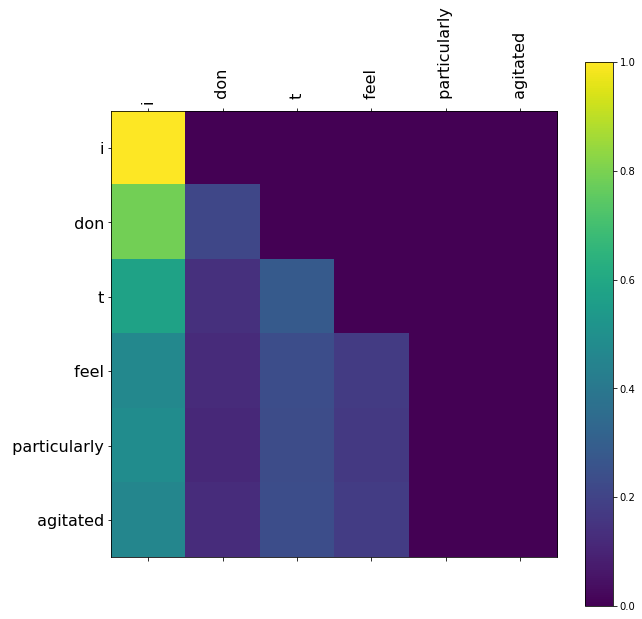

In [42]:
attns, seq = get_attention_matrixes(model_0, tokenizer, text)
show_attention(seq, attns[-1][0])

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [43]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=6
).to(device)

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
lr = 1e-3 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)
#criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=250)

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [46]:
from tqdm.notebook import tqdm


num_epochs = 3

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        targets = batch['target'].squeeze().to(device)
        answer = model_1(input_ids=inputs.squeeze().to(device), attention_mask=mask.squeeze().to(device), labels=targets.to(device))
        loss = answer['loss']
        train_loss += loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch['input_ids'].squeeze().to(device)
            mask = batch['mask'].squeeze().to(device)
            targets = batch['target'].squeeze().to(device)
            answer = model_1(input_ids=inputs.squeeze().to(device), attention_mask=mask.squeeze().to(device), labels=targets.to(device))
            loss = answer['loss']
            valid_loss += loss
            valid_acc += sum(F.softmax(answer['logits'],dim=1).argmax(dim=1) == batch['target'].to(device))/batch_size
            
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids'].squeeze().to(device)
        mask = batch['mask'].squeeze().to(device)
        targets = batch['target'].squeeze().to(device)
        answer = model_1(input_ids=inputs.squeeze().to(device), attention_mask=mask.squeeze().to(device), labels=targets.to(device))
        test_acc += sum(F.softmax(answer['logits'],dim=1).argmax(dim=1) == batch['target'].to(device))/batch_size
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.5041462779045105,Valid Loss: 0.14492255449295044,Valid Acc: 0.91162109375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.11864906549453735,Valid Loss: 0.14492255449295044,Valid Acc: 0.91162109375


  0%|          | 0/250 [00:00<?, ?it/s]

Train Loss: 0.1210639476776123,Valid Loss: 0.14492255449295044,Valid Acc: 0.91162109375
Test Acc: 0.9130859375


Есть ли прирост качества или скорости обучения?
прироста в скорости нет, там секунд на 10 эпоха стала больше вычисляться, однако в качестве был прирост явный

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?
отличия есть и заметные, здесь очевидно адекватнее обращается внимание на нужные слова

In [54]:
text = emotion_dataset["test"]["text"][10]
tokens = tokenizer.tokenize(text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


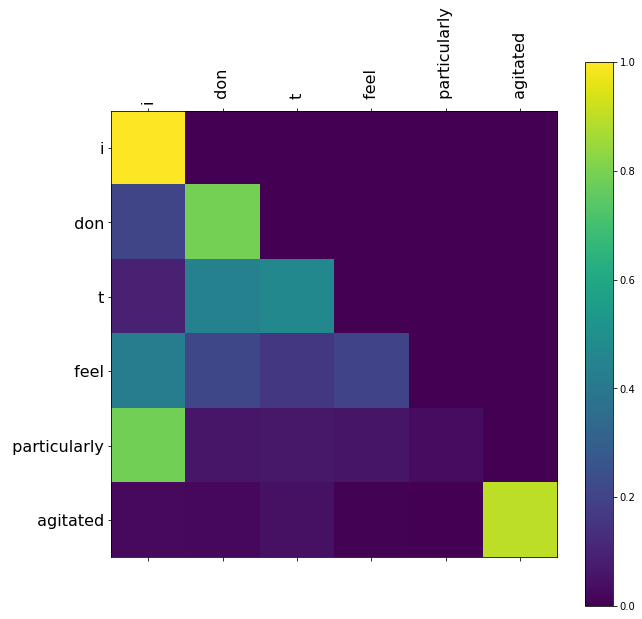

In [55]:
attns, seq = get_attention_matrixes(model_1, tokenizer, text)
show_attention(seq, attns[-1][0])

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?

< твой отчет/ответы >

C подходом fine-tuning модель показала лучшие результаты.
Модель видела взаимосвязь между существительными и глаголами, а так же глаголами и наречиями, что вполне логичо. Так же она понимает, что отрицание относится именнно к глаголу. Заметим так же что при больших предложениях внимание ослабевает. Так же в отличие от не предобученной модели, у данной модели внимание выражено более четко. На предыдущей модели на больших предложениях почти не было видно внимания между далекими словами. А в этой какое-то да внимание адекватное, пусть даже между далекими словами присутствует